# Gradient Boosting Tree (GBT) Training and Analysis

In [8]:
import sqlite3
import os
from datetime import datetime
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

# Import Data from Database

In [9]:
# connect to the database
conn = sqlite3.connect('../features.db')
c = conn.cursor()
# get training, validation and test data
train = pd.read_sql_query("SELECT * FROM train", conn)
valid = pd.read_sql_query("SELECT * FROM validation", conn)
test = pd.read_sql_query("SELECT * FROM test", conn)
# close the connection
conn.close()

## Format Data for Machine Learning

In [10]:
# get the target and features
train_y = train['y']
train_y = train_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
train_x = train.drop(columns=['y'])

valid_y = valid['y']
valid_y = valid_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
valid_x = valid.drop(columns=['y'])

test_y = test['y']
test_y = test_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
test_x = test.drop(columns=['y'])

# drop id column
train_x = train_x.drop(columns=['id'])
valid_x = valid_x.drop(columns=['id'])
test_x = test_x.drop(columns=['id'])

print('train_x shape:', train_x.shape)
print('test_x shape:', test_x.shape)
print('valid_x shape:', valid_x.shape)
# print column names
print('features:', train_x.columns.to_list())
feature_names = train_x.columns.to_list()

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

train_x = imputer.fit_transform(train_x)
valid_x = imputer.transform(valid_x)
test_x = imputer.transform(test_x)

# Scale Data between 0 and 1
scaler = MinMaxScaler()
# Fit the scaler to your data and then transform it
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)



# use xgboost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
dtest = xgb.DMatrix(test_x, label=test_y)

num_classes= len(set(valid_y.to_list()))
print('number of classes:', num_classes)

train_x shape: (3502, 10)
test_x shape: (438, 10)
valid_x shape: (438, 10)
features: ['age', 'gender', 'artial_rate', 'ventricular_rate', 'qrs_duration', 'qt_length', 'qrs_count', 'q_peak', 'r_axis', 't_axis']
number of classes: 4


# Test Grid for Hyperparameter Analysis

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5],
}#  'random_stat': 42

In [12]:
# Create a XGBClassifier object
model = GradientBoostingClassifier()

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')


## Training

In [13]:
%%time
# Fit the grid search object to the data
grid_search.fit(train_x, train_y)

CPU times: total: 2min 49s
Wall time: 4min 28s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

# Results

In [14]:
# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
#{'eta': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score: 0.7969733696438982


## Save Model

In [15]:
# Save the best model
best_model = grid_search.best_estimator_
# timestamp
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
model_path = f'../ml_models/best_gbt_model_{timestamp}.joblib'
dump(best_model, model_path)

['../ml_models/best_gbt_model_20240612171757.joblib']

# Example Training of best Model

load the best model to get the best hyperparameters from it

In [16]:
# list directory
models = os.listdir('../ml_models')
model_path = [model for model in models if 'joblib' in model and 'best' in model and 'gbt' in model][0]
model_path = f'../ml_models/{model_path}'
# load the best model
best_model = load(model_path)

In [17]:
# example training of a model with the best parameters
eval_result = {}
model = GradientBoostingClassifier(**grid_search.best_params_)
model.fit(train_x, train_y)

GradientBoostingClassifier()

In [18]:
preds = best_model.predict(test_x)
accuracy = accuracy_score(test_y, preds)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.819634703196347


# Evaluate Model Performance

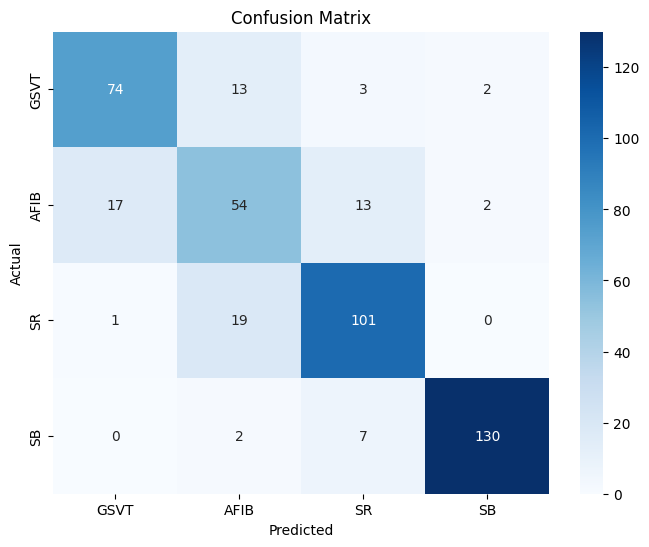

In [19]:
# Get the confusion matrix
cm = confusion_matrix(test_y, preds)

# Create a new figure
plt.figure(figsize=(8, 6))

labels = ['GSVT', 'AFIB', 'SR', 'SB']
# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

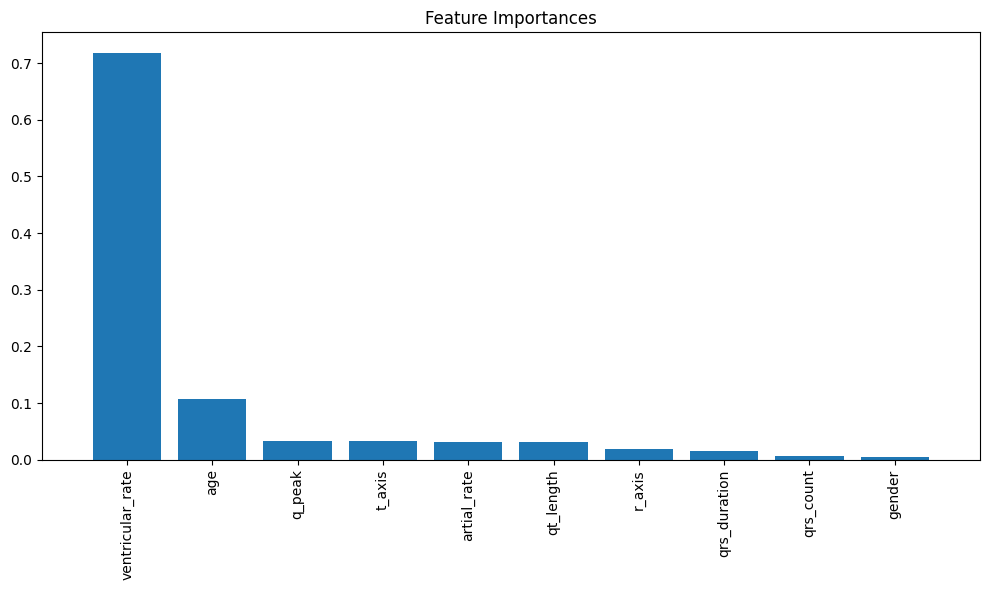

In [20]:
# plot the feature importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.feature_importances_
# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()

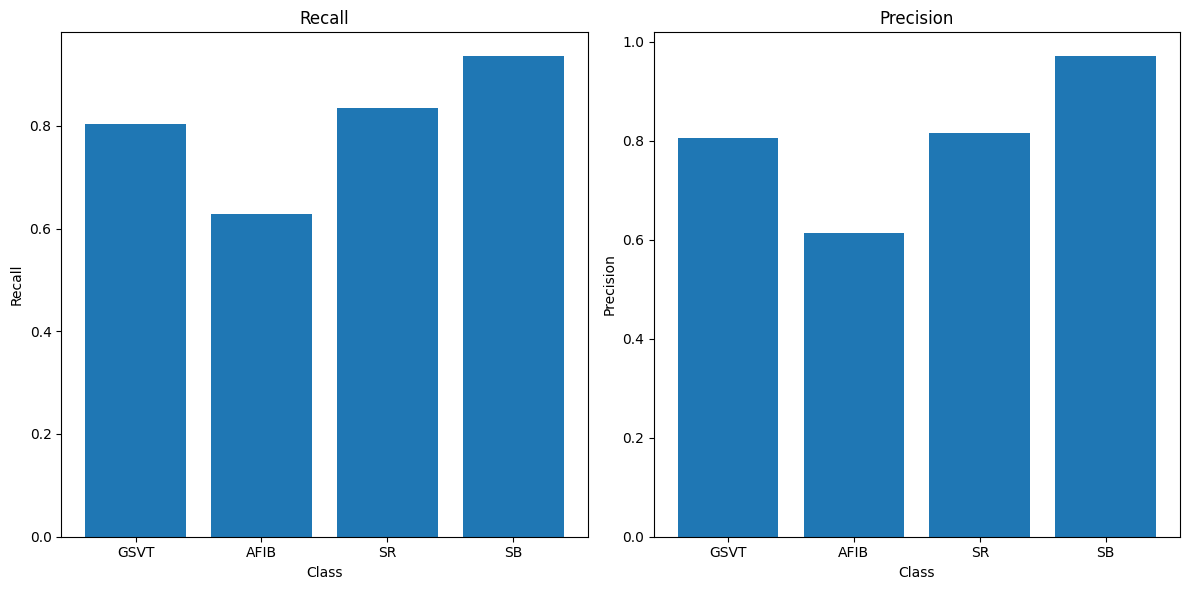

In [21]:
# plot recall and precision
# Calculate the recall and precision
recall = cm.diagonal() / cm.sum(axis=1)
precision = cm.diagonal() / cm.sum(axis=0)

# plot in a bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(num_classes), recall)
ax[0].set_xticks(range(num_classes))
ax[0].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Recall')
ax[0].set_title('Recall')

ax[1].bar(range(num_classes), precision)
ax[1].set_xticks(range(num_classes))
ax[1].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision')

plt.tight_layout()
plt.show()

In [22]:
# Calculate F1 Score for multiclass classification
f1 = f1_score(test_y, preds, average='macro')

print('F1 Score:', f1)

F1 Score: 0.8004770573896727
